In [3]:
import cv2
import numpy as np
import os
import pytesseract as pt
import matplotlib.pyplot as plt

In [2]:
#settings
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

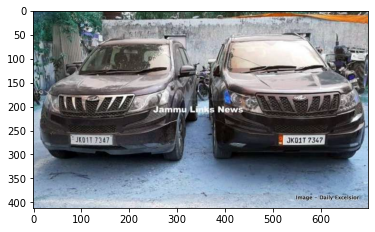

In [4]:
# Load the image
img = cv2.imread('./mahindra-xuv500-same-number-plate.jpeg')
plt.imshow(img)

In [15]:
# load the pre-trained model
net = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


In [17]:
def get_detections(img,net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    # FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [18]:
# predictions
def yolo_predictions(img,net):
    ## step-1: detections
    input_image, detections = get_detections(img,net)
    ## step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    ## step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [19]:
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return ''
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

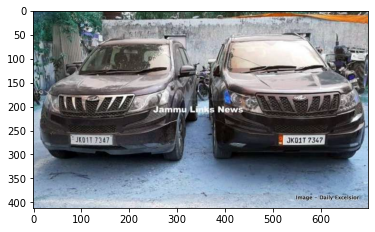

In [24]:
# test
img = cv2.imread('./mahindra-xuv500-same-number-plate.jpeg')
plt.imshow(img)

results = yolo_predictions(img,net)